# Objectifs du projet

Le but de ce projet est de prédire la popularité d'un film selon certaines caractéristiques du film

# Chargement des données
J'ai remarqué que importer directement les données via pandas prenais trop de temps. J'ai donc opté pour une lecture et un chargement des données du fichier ligne par ligne dans une liste. J'ai ensuite convertis cette liste en dataframe pandas.

In [1]:
import json

lines = []
with open("data.json", "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        if i >= 10000:
            break
        lines.append(json.loads(line))

In [2]:
import pandas as pd

df = pd.DataFrame(lines)
df = df[['adult', 'video', 'budget', 'genres', 'revenue', 'runtime', 'popularity', 'vote_count', 'release_date', 
         'vote_average', 'origin_country', 'spoken_languages', 'original_language']]
df.head()

,adult,video,budget,genres,revenue,runtime,popularity,vote_count,release_date,vote_average,origin_country,spoken_languages,original_language
0,False,False,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...",0,70,0.2989,8,1938-11-30,7.1,[US],"[{'name': 'English', 'iso_639_1': 'en', 'engli...",en
1,False,False,0,"[{'id': 12, 'name': 'Adventure'}]",0,420,0.0882,0,1921-01-01,0.0,[DE],[],de
2,False,False,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",0,120,0.3062,50,1962-06-22,6.7,"[FR, IT, JP, PL]","[{'name': 'Français', 'iso_639_1': 'fr', 'engl...",fr
3,False,False,0,[],0,69,0.0723,3,2008-12-08,6.0,[US],"[{'name': 'English', 'iso_639_1': 'en', 'engli...",en
4,False,True,0,"[{'id': 10751, 'name': 'Family'}]",0,46,0.0000,0,2010-01-05,0.0,[US],[],en


# Pré - traitement

Afin de n'avoir que des valeurs numérique, j'ai convertis les valeurs booléenne en int: 0 pour False et 1 pour True 

In [3]:
df = df.replace({True: 1, False: 0})

C:\Users\dyath\AppData\Local\Temp\ipykernel_2556\3074727906.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({True: 1, False: 0})


Dans la même optique j'ai labélisé les colonnes catégorielles

In [4]:
lang_df = pd.DataFrame(df['original_language'].unique(), columns=['original_language'])
lang_df['lang_id'] = lang_df.index
lang_df.head()

,original_language,lang_id
0,en,0
1,de,1
2,fr,2
3,fi,3
4,he,4


In [5]:
df = df.merge(lang_df, on='original_language', how='left')
df = df.drop(columns=['original_language'])
df = df.rename(columns={'lang_id': 'original_language'})

Certains champs, comme le genre du film pouvaient contenir plusieurs valeurs donc j'en ai fait des colonnes suplémentaires avec comme valeur 0 et 1

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer

def encode_multi_label_col(df, col, list_it=True):
    new_col = col
    if list_it: 
        new_col = col + '_list'
        df[new_col] = df[col].apply(lambda x: [d['name'] for d in x] if isinstance(x, list) else [])

    mlb = MultiLabelBinarizer()
    col_encoded = pd.DataFrame(mlb.fit_transform(df[new_col]), columns=mlb.classes_, index=df.index)
    
    if list_it: df = df.drop(new_col, axis=1)
    
    return col_encoded

In [7]:
cols = ['genres', 'spoken_languages']

for col in cols:
    col_encoded = encode_multi_label_col(df, col)
    print(col, ':', col_encoded.columns)
    df = pd.concat([df, col_encoded], axis=1)

col = 'origin_country'
col_encoded = encode_multi_label_col(df, col, list_it=False)
print(col, ':', col_encoded.columns)
df = pd.concat([df, col_encoded], axis=1)

genres : Index(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery',
       'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western'],
      dtype='object')
spoken_languages : Index(['', 'Afrikaans', 'Bahasa indonesia', 'Bahasa melayu', 'Bamanankan',
       'Bosanski', 'Català', 'Cymraeg', 'Dansk', 'Deutsch', 'Eesti', 'English',
       'Español', 'Esperanto', 'Français', 'Gaeilge', 'Galego', 'Hrvatski',
       'Italiano', 'Kinyarwanda', 'Kiswahili', 'Latin', 'Lietuvių', 'Magyar',
       'Malti', 'Nederlands', 'No Language', 'Norsk', 'Polski', 'Português',
       'Pусский', 'Română', 'Slovenčina', 'Slovenščina', 'Somali', 'Srpski',
       'Tiếng Việt', 'Türkçe', 'euskera', 'isiZulu', 'shqip', 'suomi',
       'svenska', 'Èʋegbe', 'Íslenska', 'Český', 'ελληνικά', 'Український',
       'беларуская мова', 'български език', 'қазақ', 'עִבְרִית', 'اردو',
       'العربية', 'فارسی', 'پښتو

In [8]:
df = df.drop(['genres', 'spoken_languages', 'origin_country', 'genres_list', 'spoken_languages_list'], axis=1)

In [9]:
df.columns

Index(['adult', 'video', 'budget', 'revenue', 'runtime', 'popularity',
       'vote_count', 'release_date', 'vote_average', 'original_language',
       ...
       'UA', 'US', 'UY', 'UZ', 'VE', 'VI', 'XC', 'XG', 'YU', 'ZA'],
      dtype='object', length=191)

La date était sur un format textuelle. J'ai donc modifié cela et récupéré que l'année.

In [10]:
from datetime import datetime
df['release_year'] = df['release_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').year if x else None)
df = df.drop('release_date', axis=1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 191 entries, adult to release_year
dtypes: float64(3), int32(181), int64(7)
memory usage: 7.7 MB


Au niveau des colones catégorielles, j'ai remplacé les champs vides par None

In [12]:
cat_cols = df.select_dtypes(include='object').columns

df[cat_cols] = df[cat_cols].replace('', None)

# Exploration des données

In [13]:
main_cols = ['adult', 'video', 'budget', 'revenue', 'runtime', 'popularity', 'vote_count', 'release_year', 'vote_average', 'original_language']

df[main_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   adult              10000 non-null  int64  
 1   video              10000 non-null  int64  
 2   budget             10000 non-null  int64  
 3   revenue            10000 non-null  int64  
 4   runtime            10000 non-null  int64  
 5   popularity         10000 non-null  float64
 6   vote_count         10000 non-null  int64  
 7   release_year       9995 non-null   float64
 8   vote_average       10000 non-null  float64
 9   original_language  10000 non-null  int64  
dtypes: float64(3), int64(7)
memory usage: 781.4 KB


In [14]:
df[main_cols].describe()

,adult,video,budget,revenue,runtime,popularity,vote_count,release_year,vote_average,original_language
count,10000.0,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,9995.000000,10000.000000,10000.000000
mean,0.0,0.012500,1.167048e+07,3.243486e+07,100.319700,2.495973,934.576500,1992.150175,6.023449,1.980700
std,0.0,0.111108,2.527688e+07,9.311402e+07,28.547672,4.485322,2330.592085,18.168027,1.590685,5.335501
min,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1888.000000,0.000000,0.000000
25%,0.0,0.000000,0.000000e+00,0.000000e+00,90.000000,0.360275,28.000000,1984.000000,5.600000,0.000000
50%,0.0,0.000000,0.000000e+00,0.000000e+00,98.000000,1.074300,195.000000,1999.000000,6.300000,0.000000
75%,0.0,0.000000,1.200000e+07,2.142057e+07,111.000000,2.756850,750.000000,2006.000000,6.972000,1.000000
max,0.0,1.000000,3.790000e+08,2.264162e+09,460.000000,156.044900,33793.000000,2025.000000,10.000000,57.000000


In [15]:
df[main_cols].isna().sum()

adult                0
video                0
budget               0
revenue              0
runtime              0
popularity           0
vote_count           0
release_year         5
vote_average         0
original_language    0
dtype: int64

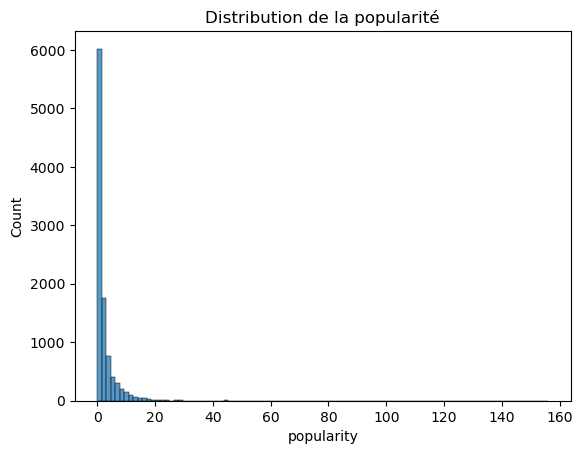

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['popularity'], bins=100)
plt.title('Distribution de la popularité')
plt.show()

On remarque ici que les données ne sont pas bien représentés, puisque j'ai beaucoup plus de lignes avec une popularité = 0 (environ 6000 lignes sur 10000)

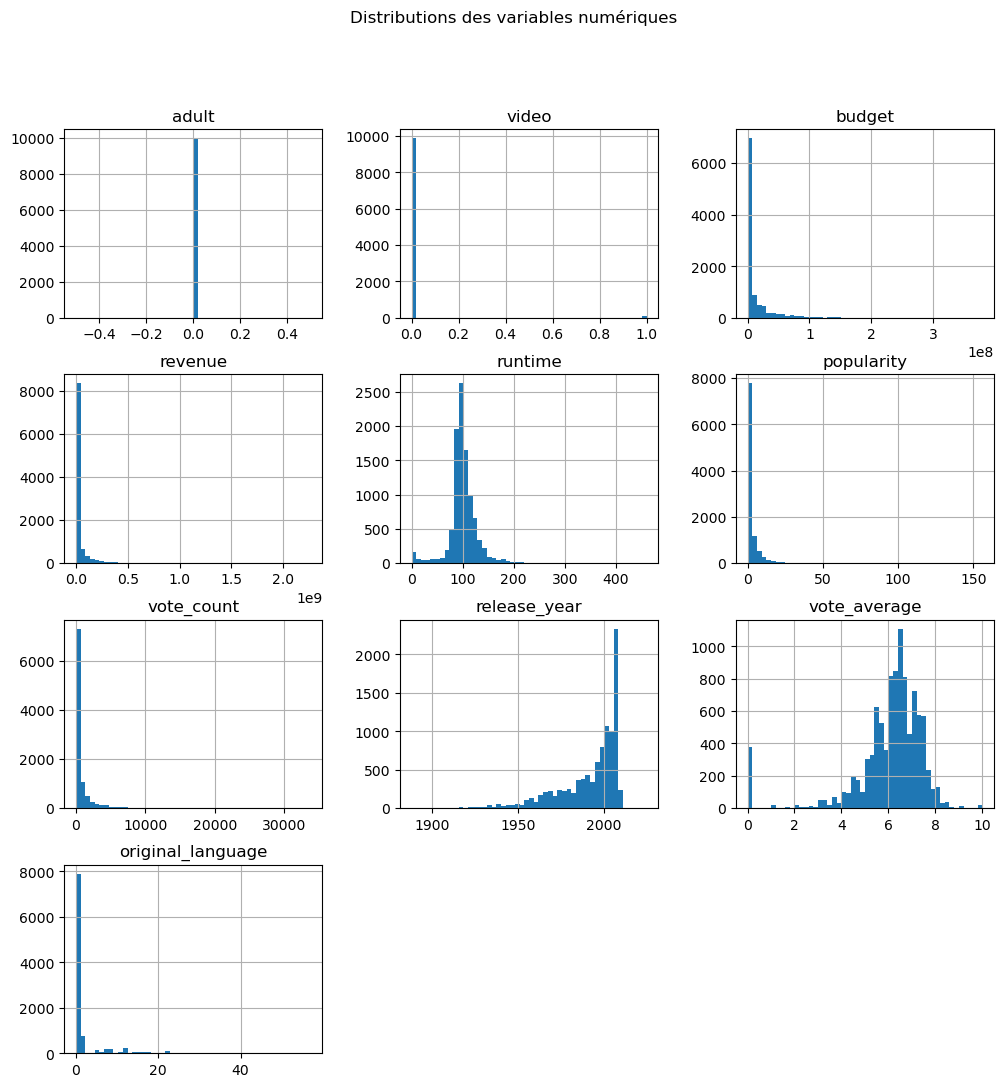

In [17]:
df[main_cols].hist(bins=50, figsize=(12, 12))
plt.suptitle('Distributions des variables numériques')
plt.show()

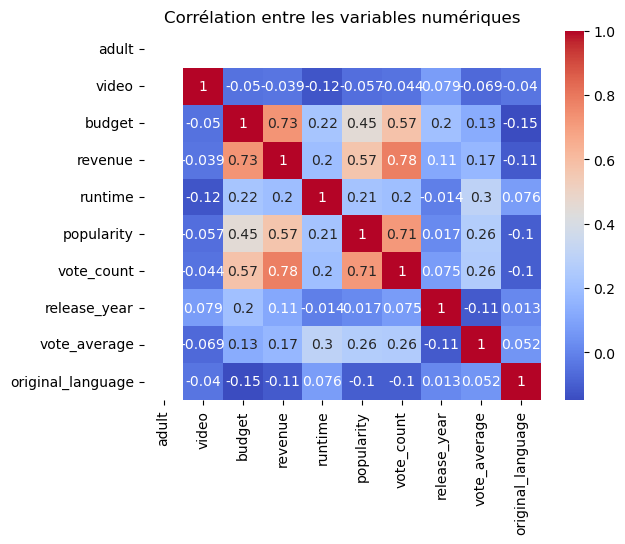

In [18]:
sns.heatmap(df[main_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Corrélation entre les variables numériques")
plt.show()

# Implémentation du model

J'ai opté pour le RandomForestRegressor

In [19]:
from sklearn.model_selection import train_test_split

y = df['popularity']
X = df.drop('popularity', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Modèle
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.4f}')
print(f'R²: {r2:.4f}')


RMSE: 2.7872
R²: 0.4611


C:\Users\dyath\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


J'ai obtenue une performance pas très acceptable donc j'ai décidé de refaire un travail sur mes données en commençant par les normaliser

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modèle
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.4f}')
print(f'R²: {r2:.4f}')

RMSE: 2.7950
R²: 0.4581


C:\Users\dyath\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Malgré tout, les résultats n'ont pas vraiment changé avec ce model. J'ai donc testé le DecisionTreeRegressor. Dans le but d'avoir des hyperparamètres optimaux j'ai testé plusieurs valeurs de profondeur.

In [23]:
from sklearn.tree import DecisionTreeRegressor

def train_model(max_depth):
    model = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    result = {
        'max_depth': max_depth,
        'r2_train': r2_train,
        'r2_test': r2_test
    }

    return result

In [24]:
model_result_list = []

for depth in range(1,5):
    model_result = train_model(depth)
    model_result_list.append(model_result)

model_result_df = pd.DataFrame(model_result_list)
model_result_df.head()

,max_depth,r2_train,r2_test
0,1,0.348761,0.504787
1,2,0.502324,0.563497
2,3,0.644976,0.006838
3,4,0.719295,0.005925


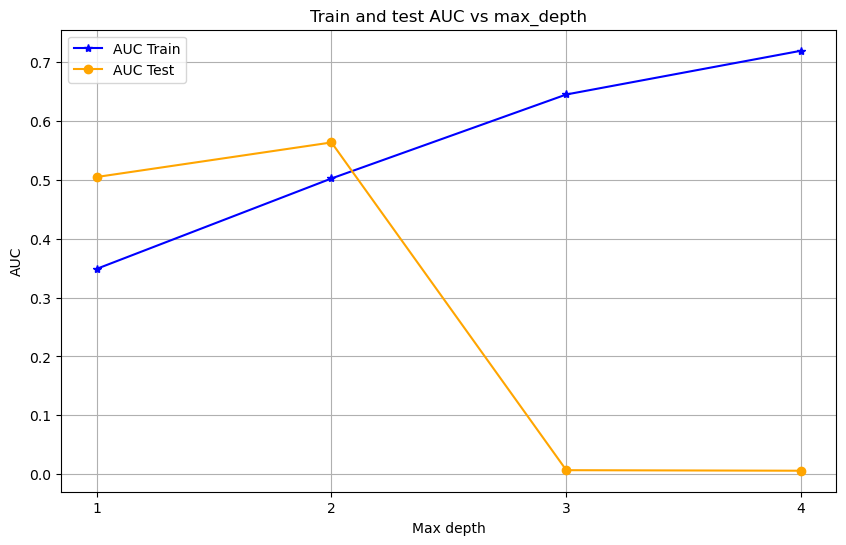

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(model_result_df["max_depth"], model_result_df["r2_train"], marker='*', label="AUC Train", color='blue')
plt.plot(model_result_df["max_depth"], model_result_df["r2_test"], marker='o', label="AUC Test", color='orange')

plt.title("Train and test AUC vs max_depth")
plt.xlabel("Max depth")
plt.ylabel("AUC")
plt.xticks(model_result_df["max_depth"])
plt.grid(True)
plt.legend()
plt.show()

Avec celui-ci j'ai un meilleure score mais toujours pas assez bien. Je remarque égalment que lorsqu'on s'intéresse plus en profondeur on données on perd en précision sur le modele.

J'ai essayé le LinearRegression cette fois-ci

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')  # ou 'median'
X_scaled_imputed = imputer.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_scaled_imputed, y, test_size=0.2, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_y_pred = lr_model.predict(X_test)

rmse = mean_squared_error(y_test, lr_y_pred, squared=False)
r2 = r2_score(y_test, lr_y_pred)

print(f'RMSE: {rmse:.4f}')
print(f'R²: {r2:.4f}')

RMSE: 1275890039306.7500
R²: -112926347399462144442368.0000


C:\Users\dyath\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Là c'est vraiment une catastrophe. Donc je pense qu nous allons rester sur le model avec le DecisionTreeRegressor. Je pense que si nous avions des données comme le résumé du film, les acteurs, les réalisateurs, la maison d'edidition, etc, et que les données étaient mieux réparties, on aurait pu avoir de meileurs résultats.

# Model final

In [27]:
model = DecisionTreeRegressor(max_depth=2, random_state=42)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

r2_test = r2_score(y_test, y_test_pred)

print(r2_test)

0.563496780806068


## Deployement

In [28]:
list(X.columns)

['adult',
 'video',
 'budget',
 'revenue',
 'runtime',
 'vote_count',
 'vote_average',
 'original_language',
 'Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western',
 '',
 'Afrikaans',
 'Bahasa indonesia',
 'Bahasa melayu',
 'Bamanankan',
 'Bosanski',
 'Català',
 'Cymraeg',
 'Dansk',
 'Deutsch',
 'Eesti',
 'English',
 'Español',
 'Esperanto',
 'Français',
 'Gaeilge',
 'Galego',
 'Hrvatski',
 'Italiano',
 'Kinyarwanda',
 'Kiswahili',
 'Latin',
 'Lietuvių',
 'Magyar',
 'Malti',
 'Nederlands',
 'No Language',
 'Norsk',
 'Polski',
 'Português',
 'Pусский',
 'Română',
 'Slovenčina',
 'Slovenščina',
 'Somali',
 'Srpski',
 'Tiếng Việt',
 'Türkçe',
 'euskera',
 'isiZulu',
 'shqip',
 'suomi',
 'svenska',
 'Èʋegbe',
 'Íslenska',
 'Český',
 'ελληνικά',
 'Український',
 'беларуская мова',
 'български език',
 'қазақ',
 'עִבְרִ

In [29]:
import joblib

joblib.dump(model, 'model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(list(X.columns), 'expected_columns.pkl')

['expected_columns.pkl']

## Création d'une application streamlit

In [30]:
# voir le fichier app.py